# Detecting Contradiction and Entailment in Multilingual Text

1. Data Exploration and Preprocessing
2. Model Training
3. Model Retraining and Tuning

### Libraries

In [ ]:
%pip install pandas transformers tensorflow
import pandas as pd
import numpy as np
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Reshape, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input, optimizers, regularizers


## 1. Data Exploration and Preprocessing

In [2]:
dataframe = pd.read_csv('data/train.csv')

# Preprocess data
dataframe['premise'] = dataframe['premise'].apply(lambda x: x.lower()) # Convert premise to lowercase
dataframe['hypothesis'] = dataframe['hypothesis'].apply(lambda x: x.lower()) # Convert hypothesis to lowercase
dataframe['premise'] = dataframe['premise'].str.replace('[^\w\s]','') # Remove punctuation from premise
dataframe['hypothesis'] = dataframe['hypothesis'].str.replace('[^\w\s]','') # Remove punctuation from hypothesis
dataframe['premise'] = dataframe['premise'].str.replace('\d+', '') # Remove digits from premise
dataframe['hypothesis'] = dataframe['hypothesis'].str.replace('\d+', '') # Remove digits from hypothesis
dataframe['premise'] = dataframe['premise'].str.replace('\n','') # Remove newlines from premise
dataframe['hypothesis'] = dataframe['hypothesis'].str.replace('\n','') # Remove newlines from hypothesis

In [3]:
dataframe.head(10)

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,the rules developed in the interim were put to...,en,English,0
1,5b72532a0b,these are issues that we wrestle with in pract...,practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,des petites choses comme celles-là font une di...,j'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,they can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
5,ed7d6a1e62,"bir çiftlikte birisinin, ağıla kapatılmış bu ö...",çiftlikte insanlar farklı terimler kullanırlar.,tr,Turkish,0
6,5a0f4908a0,ریاست ہائے متحدہ امریکہ واپس آنے پر، ہج ایف بی...,ہیگ کی تفتیش ایف بی آئی اہلکاروں کی طرف سے کی...,ur,Urdu,0
7,fdcd1bd867,from cockpit country to st. ann's bay,from st. ann's bay to cockpit country.,en,English,2
8,7cfb3d272c,"look, it's your skin, but you're going to be i...",the boss will fire you if he sees you slacking...,en,English,1
9,8c10229663,через каждые сто градусов пятна краски меняют ...,краска изменяется в соответствии с цветом.,ru,Russian,0


#### Visualization

In order to see the language distribution, we can check the pie chart below.

In [4]:
def visualize(df, column):
  labels, frequencies = np.unique(df[column].values, return_counts = True)
  plt.figure(figsize = (10,10))
  plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
  plt.show()

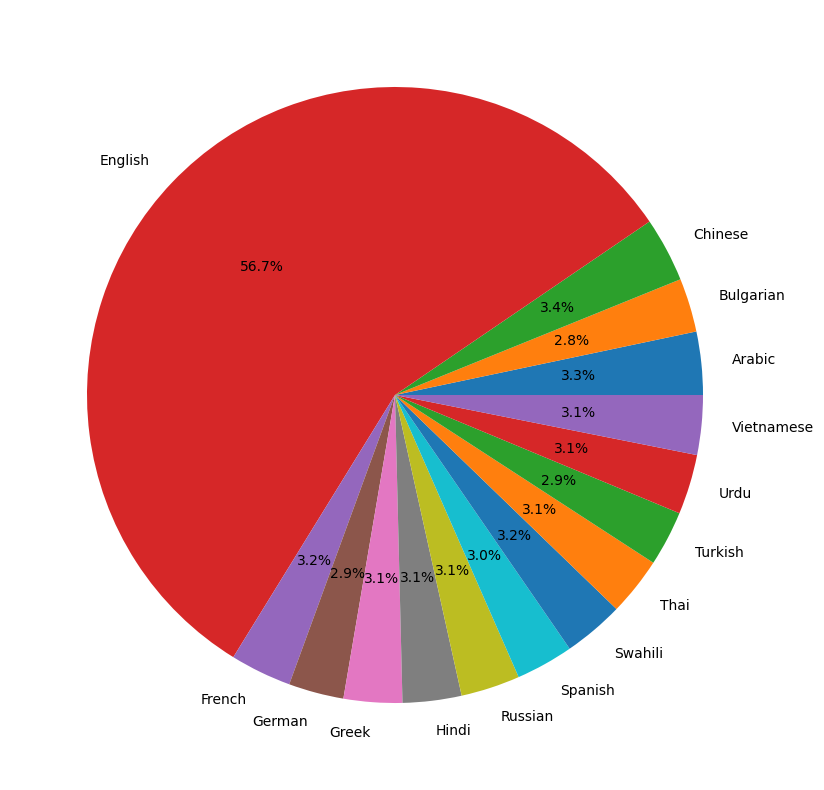

In [5]:
visualize(dataframe, 'language')

We can also see the label distribution is almost equal, where:
 - 0 - entailement
 - 1 - neutral
 - 2 - contradiction

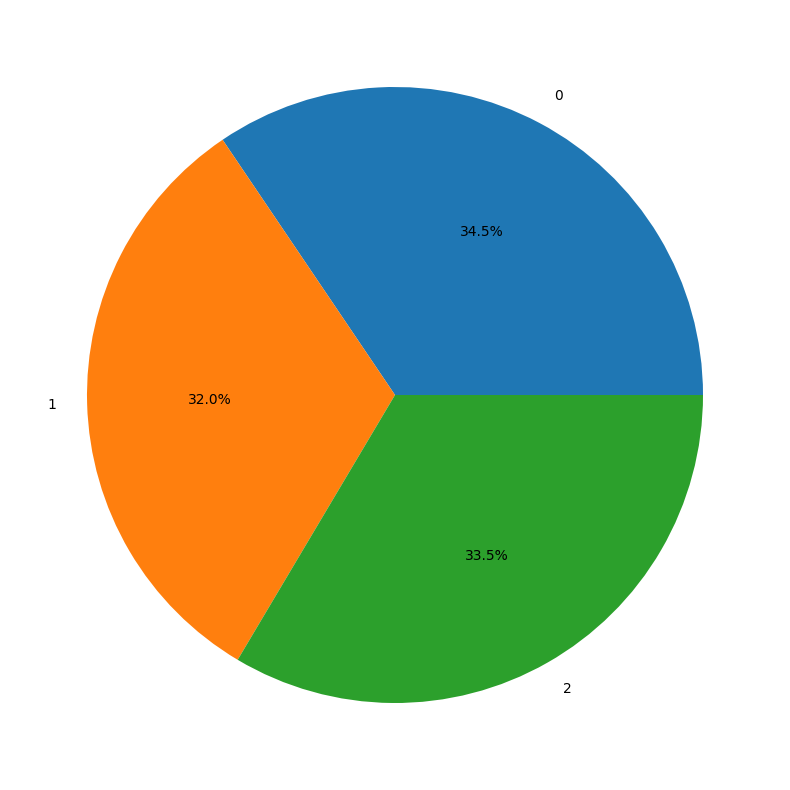

In [6]:
visualize(dataframe, 'label')

## 2. Model Training

### Representation

BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. 


First we have preprocessing the CSV data so it can fit with the BERT algorithm.

In [ ]:
model_name = 'bert-base-multilingual-cased'
MAX_LENGTH = 512  # adjust as needed, up to a max of 512 for BERT, otherwise it will cut off

train_df, test_df = train_test_split(dataframe, test_size=0.2, random_state=42, stratify=dataframe['label'])


# Encode data using BERT
tokenizer = BertTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(list(train_df['premise']), list(train_df['hypothesis']),
                            truncation=True, padding='max_length', max_length=MAX_LENGTH)
test_encodings = tokenizer(list(test_df['premise']), list(test_df['hypothesis']),
                           truncation=True, padding='max_length', max_length=MAX_LENGTH)


train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_df['label'].values
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_df['label'].values
))

bert_model = TFBertModel.from_pretrained(model_name)

### Model Training For Prediction

Now we define our sequential RNN model with LSTM to do the predicting for the Label. We also use the Adam optimizer. 

In [8]:
def train_model(model, train_dataset, test_dataset, batch_size=32, validation_batch_size=64, epochs=5):
    model.fit(train_dataset.batch(batch_size), 
              epochs=epochs, 
              validation_data=test_dataset.batch(validation_batch_size))

In [9]:
def create_model(bert_model, 
                 lstm_dim=64, 
                 learning_rate=0.001, 
                 dropout_rate=0.1, 
                 clipnorm=1.0, 
                 optimizer_type='Adam',
                 regularizer_type=None,
                 regularization_rate=0.01):

    input_ids = Input(shape=(None,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(None,), dtype=tf.int32, name='attention_mask')

    sequence_output = bert_model(input_ids, attention_mask=attention_mask)[0]

    if regularizer_type == 'L1':
        output = LSTM(lstm_dim, kernel_regularizer=regularizers.l1(regularization_rate))(sequence_output)
    elif regularizer_type == 'L2':
        output = LSTM(lstm_dim, kernel_regularizer=regularizers.l2(regularization_rate))(sequence_output)
    else:
        output = LSTM(lstm_dim)(sequence_output)

    output = Dropout(dropout_rate)(output)

    output = Dense(3, activation='softmax')(output)

    model = Model(inputs=[input_ids, attention_mask], outputs=output)

    if optimizer_type == 'Adam':
        opt = optimizers.Adam(learning_rate=learning_rate, clipnorm=clipnorm)
    elif optimizer_type == 'RMSprop':
        opt = optimizers.RMSprop(learning_rate=learning_rate, clipnorm=clipnorm)
    else:
        raise ValueError('Invalid optimizer_type')

    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


## 3. Model Retraining and Tuning 

Now, in order for improving and fine tuning the model, we have a few different parameters that can have various values:

- lstm_dim: The number of output units in the LSTM layer.
- learning_rate: The size of the steps taken to reach a (local) minimum in the optimization process.
- dropout_rate: The proportion of neurons in a layer that are randomly ignored (or "dropped out") during training.
- clipnorm: A threshold value for gradient clipping, which can prevent exploding gradients in neural networks.
- optimizer_type: The algorithm used to change the attributes of the neural network such as weights and learning rate in order to reduce the losses.
- regularizer_type: Regularization strategy used to prevent overfitting. L1 or L2 refers to the order of the norm used in the regularization term.
- regularization_rate: The scalar multiplier for the regularization term in the loss function.
- batch_size: The number of training examples utilized in one iteration.
- epochs: An epoch is a complete pass through the entire training dataset.

In [10]:
param_sets = [
    {
        "lstm_dim": 64,
        "learning_rate": 0.001,
        "dropout_rate": 0.1,
        "clipnorm": 1.0,
        "optimizer_type": 'Adam',
        "regularizer_type": 'L1',
        "regularization_rate": 0.01,
        "batch_size": 32,
        "epochs": 5
    },
    {
        "lstm_dim": 128,
        "learning_rate": 0.002,
        "dropout_rate": 0.2,
        "clipnorm": 1.0,
        "optimizer_type": 'RMSprop',
        "regularizer_type": 'L2',
        "regularization_rate": 0.02,
        "batch_size": 64,
        "epochs": 10
    },
    {
        "lstm_dim": 256,
        "learning_rate": 0.001,
        "dropout_rate": 0.2,
        "clipnorm": 1.0,
        "optimizer_type": 'Adam',
        "regularizer_type": 'L1',
        "regularization_rate": 0.01,
        "batch_size": 64,
        "epochs": 7
    },
    {
        "lstm_dim": 128,
        "learning_rate": 0.005,
        "dropout_rate": 0.2,
        "clipnorm": 1.0,
        "optimizer_type": 'Adam',
        "regularizer_type": 'L2',
        "regularization_rate": 0.05,
        "batch_size": 32,
        "epochs": 10
    },
    {
        "lstm_dim": 64,
        "learning_rate": 0.001,
        "dropout_rate": 0.3,
        "clipnorm": 1.0,
        "optimizer_type": 'RMSprop',
        "regularizer_type": None,
        "regularization_rate": 0,
        "batch_size": 64,
        "epochs": 5
    },
    {
        "lstm_dim": 128,
        "learning_rate": 0.002,
        "dropout_rate": 0.2,
        "clipnorm": 0.5,
        "optimizer_type": 'Adam',
        "regularizer_type": 'L1',
        "regularization_rate": 0.02,
        "batch_size": 32,
        "epochs": 7
    },
    {
        "lstm_dim": 512,
        "learning_rate": 0.0005,
        "dropout_rate": 0.2,
        "clipnorm": 1.0,
        "optimizer_type": 'Adam',
        "regularizer_type": 'L1',
        "regularization_rate": 0.01,
        "batch_size": 32,
        "epochs": 3
    },
    {
        "lstm_dim": 256,
        "learning_rate": 0.0001,
        "dropout_rate": 0.3,
        "clipnorm": 1.0,
        "optimizer_type": 'RMSprop',
        "regularizer_type": 'L2',
        "regularization_rate": 0.02,
        "batch_size": 64,
        "epochs": 5
    },
    {
        "lstm_dim": 512,
        "learning_rate": 0.0003,
        "dropout_rate": 0.1,
        "clipnorm": 1.0,
        "optimizer_type": 'Adam',
        "regularizer_type": 'L2',
        "regularization_rate": 0.01,
        "batch_size": 32,
        "epochs": 8
    },
    {
        "lstm_dim": 256,
        "learning_rate": 0.0002,
        "dropout_rate": 0.2,
        "clipnorm": 0.5,
        "optimizer_type": 'RMSprop',
        "regularizer_type": 'L1',
        "regularization_rate": 0.01,
        "batch_size": 64,
        "epochs": 7
    },
    {
        "lstm_dim": 64,
        "learning_rate": 0.0005,
        "dropout_rate": 0.3,
        "clipnorm": 0.5,
        "optimizer_type": 'Adam',
        "regularizer_type": 'L2',
        "regularization_rate": 0.02,
        "batch_size": 32,
        "epochs": 5
    }
]


In [ ]:
# for params in param_sets:
# Create model with current parameter set

model = create_model(
    bert_model, 
    lstm_dim=param_sets[0]["lstm_dim"], 
    learning_rate=param_sets[0]["learning_rate"], 
    dropout_rate=param_sets[0]["dropout_rate"], 
    clipnorm=param_sets[0]["clipnorm"], 
    optimizer_type=param_sets[0]["optimizer_type"],
    regularizer_type=param_sets[0]["regularizer_type"],
    regularization_rate=param_sets[0]["regularization_rate"]
)

# Train the model
train_model(
    model, 
    train_dataset, 
    test_dataset, 
    batch_size=param_sets[0]["batch_size"], 
    epochs=param_sets[0]["epochs"]
)

